In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('paper', font_scale=1.3)
red, blue, green = sns.color_palette('Set1', 3)

import os
from datetime import datetime, timedelta
from rakott.mpl import savefig_bbox

mpl.__version__

def int_to_dt(t):
    return pd.to_datetime(start_date) + timedelta(days=t)

In [17]:
output_folder = '../output/2020-04-30-prior-walkers-model2-normal/'
%ls $output_folder/inference

Austria.npz         Germany.npz         Sweden.npz          inference.py
Belgium.npz         Italy.npz           Switzerland.npz
Denmark.npz         Norway.npz          United_Kingdom.npz
France.npz          Spain.npz           Wuhan.npz


In [36]:
country = 'Spain'

In [37]:
NPI_dates = pd.read_csv('../data/NPI_dates.csv')
official_date = pd.to_datetime(NPI_dates.loc[NPI_dates['Country'] == country.replace('_', ' '), 'Last'].values[0])

In [38]:
npz_path = os.path.join(output_folder, 'inference', '{}.npz')
data = np.load(npz_path.format(country))

In [39]:
var_names = data['var_names']
start_date = data['start_date']
start_date = pd.to_datetime(start_date)
sample = data['chain']
print(var_names)

['Z' 'D' 'μ' 'β' 'α1' 'λ' 'α2' 'E0' 'Iu0' 'τ']


In [40]:
official_date_days = (official_date - start_date).days

In [41]:
τ_sample = sample[:, :, -1]
nburn = τ_sample.shape[1]//2
τ_sample.shape

(50, 100000)

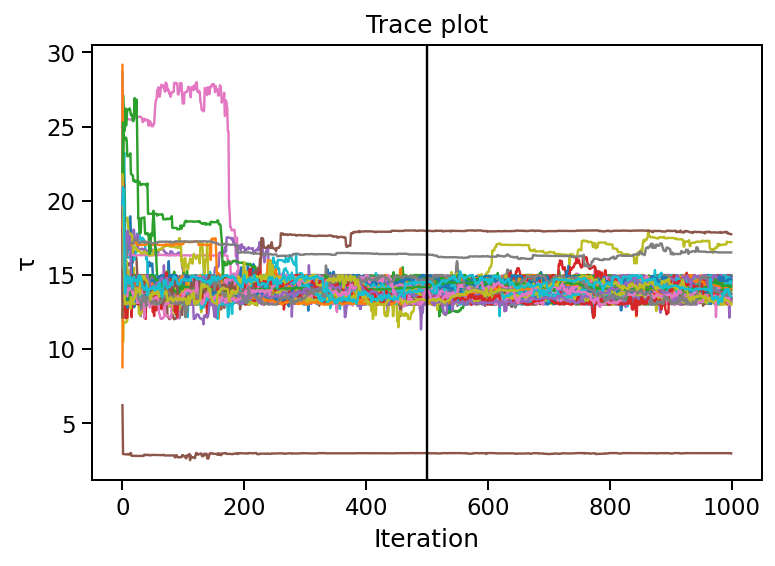

In [42]:
thin = 100
plt.plot(τ_sample[:, ::thin].T)
plt.ylabel('τ')
plt.xlabel('Iteration')
plt.title('Trace plot');
plt.axvline(nburn/thin, color='k');

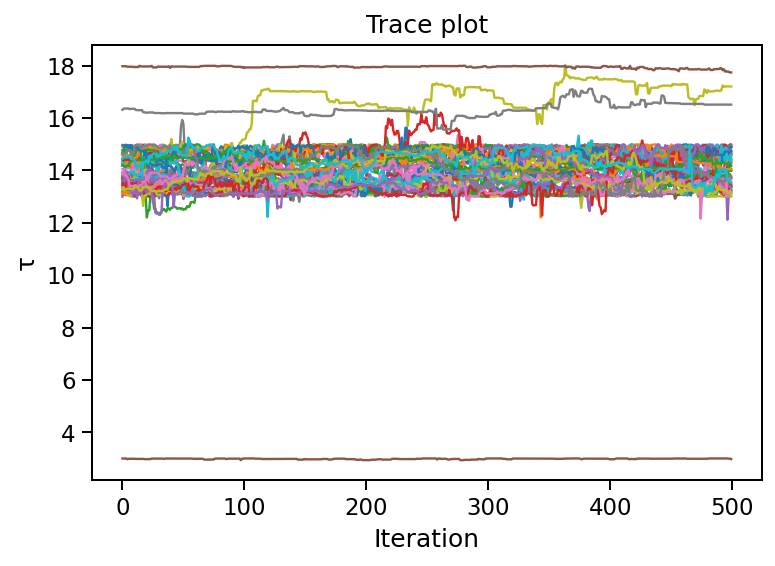

In [43]:
plt.plot(τ_sample[:,nburn::thin].T)
plt.ylabel('τ')
plt.xlabel('Iteration')
plt.title('Trace plot');

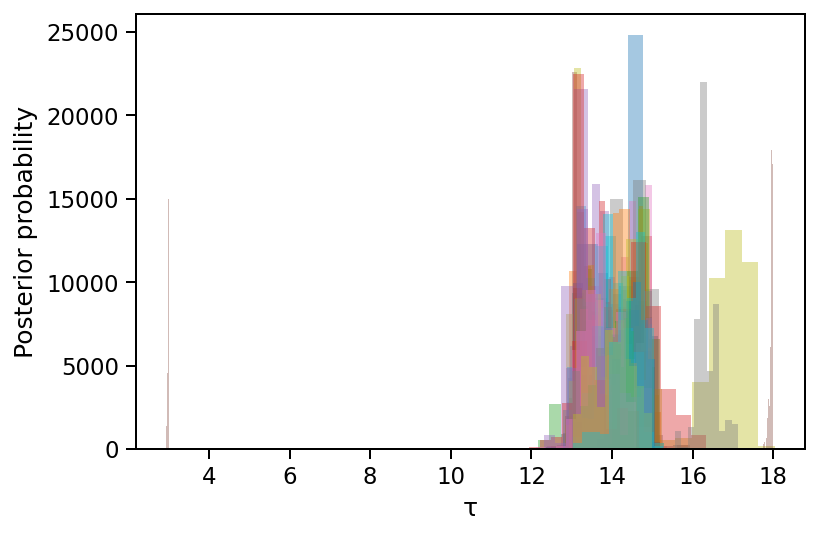

In [44]:
fig, ax = plt.subplots()
for i in range(τ_sample.shape[0]):
    ax.hist(τ_sample[i, nburn:], density=False, alpha=0.4)
ax.set(xlabel='τ', ylabel='Posterior probability');

In [45]:
τ_sample = τ_sample[:, nburn:].ravel()

In [48]:
τ_hat = np.mean(τ_sample)
print("τ_hat = {:.2f}".format(τ_hat))
quantile = 0.95
τ_ci = np.quantile(abs(τ_sample - τ_hat), quantile)
print("+-{:.2f} days for {:.2f} quantile".format(τ_ci, quantile))

τ_hat = 13.95
+-2.96 days for 0.95 quantile


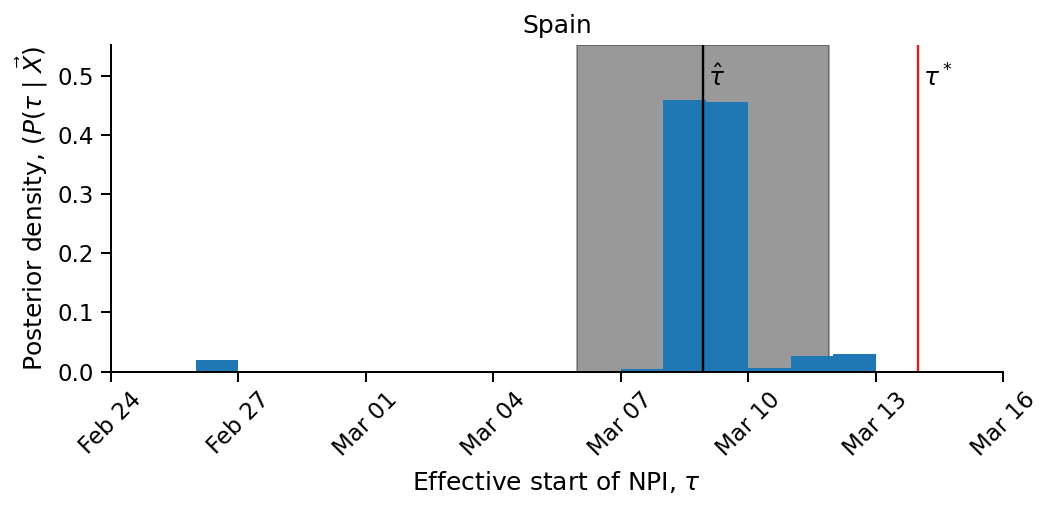

In [58]:
fig, ax = plt.subplots(figsize=(8, 3))
xmax = max(official_date_days, np.ceil(τ_sample.max())) + 2.5
density, bins, _ = ax.hist(τ_sample, bins=np.arange(0, xmax, 1), density=True, align='mid')
ymax = density.max() * 1.2
ax.axvline(τ_hat, color='k')
ax.fill_between([τ_hat - τ_ci, τ_hat + τ_ci], 0, ymax, alpha=0.4, color='k')
# ax.axvline(τ_hat + τ_ci, color='k', ls='--')
# ax.axvline(τ_hat - τ_ci, color='k', ls='--')
ax.axvline(official_date_days, color=red)
ax.set(xlabel=r'Effective start of NPI, $\tau$', 
       ylabel=r'Posterior density, $(P(\tau \mid \vec{X})$', 
       xlim=(τ_sample.min()-1, τ_sample.max()+1),
       ylim=(0, ymax)
)
days = np.arange(0, xmax, 3)
deltas = [timedelta(int(x)) for x in days]
ax.set_xticks(days);
txt = ax.set_xticklabels([(start_date + d).strftime('%b %d') for d in deltas], rotation=45)

ax.annotate(r'$\hat{\tau}$', (τ_hat+0.1, ymax*0.875))
ax.annotate(r'$\tau^*$', (official_date_days+0.1, ymax*0.875))

ax.set_title(country.replace('_', ' '))
sns.despine()

fig.savefig('../figures/{}_τ_posterior.pdf'.format(country), dpi=100, **savefig_bbox(*txt))

In [53]:
official_date_days, np.ceil(τ_sample.max())

(19, 19.0)